# 00-Basic example using the MOGPTK

_[Estimated time of execution: 5 min]_

This notebook shows the basics of the MOGPTK: how to quickly load data and train the model.

The fundamental pillars of MOGPTK are the `mogptk.Data` and `mogptk.Model` classes, where the former stores the data for each channel and the latter defines the model to use. In this tutorial we will show how to use them in a toy dataset.

This tutorial shows examples for the following covariance kernels:

* __[MOSM](https://games-uchile.github.io/mogptk/mosm.html)__ MultiOutput Spectral Mixture
*  __[CONV](https://games-uchile.github.io/mogptk/conv.html)__ Convolutional Gaussian
* __[CSM](https://games-uchile.github.io/mogptk/csm.html)__ Cross Spectral Mixture
* __[SM-LMC](https://games-uchile.github.io/mogptk/sm_lmc.html)__ Spectral Mixture - Linear Model of Corregionalization

Full documentation can be accessed here:
[__Documentation__](https://games-uchile.github.io/mogptk/)

In [1]:
import mogptk

import numpy as np
import matplotlib.pyplot as plt

## 1. Generating a toy dataset

As a toy example we generate __four noisy sinusoidal signals__, each of which is of the same frequency but they differ in phase and delay as follows

In [2]:
# create data points
# time array
n_points = 100
t = np.linspace(0, 6, n_points)

# data for channel 1
y1 = np.sin(6 * t)
# add noise
y1 += np.random.normal(scale=0.2, size=len(t))

# data for channel 2
# phased version
y2 = np.sin(6 * t + 2)
y2 += np.random.normal(scale=0.2, size=len(t))

# data for channel 3
# added sinosoidal
y3 = np.sin(6 * t) - np.sin(4 * t)
y3 += np.random.normal(scale=0.2, size=len(t))

# data for channel 4
# delayed and amplified
y4 = 3 * np.sin(6 * (t - 2))
y4 += np.random.normal(scale=0.3, size=len(t))

Then for each time series (channels) we will instantiate a [`mogptk.Data`](https://games-uchile.github.io/mogptk/data.html) class object, which will be used to create a dataset instance [`mogptk.DataSet`](https://games-uchile.github.io/mogptk/dataset.html) to be passed to the model.

More examples of data loading are in the example [01-Data Loading](https://github.com/GAMES-UChile/mogptk/blob/master/examples/01_Data_Loading.ipynb).

In [3]:
# data object for each channel
data1 = mogptk.Data(t, y1, name='First channel')
data2 = mogptk.Data(t, y2, name='Second channel')
data3 = mogptk.Data(t, y3, name='Third channel')
data4 = mogptk.Data(t, y4, name='Fourth channel')

# create dataset
dataset = mogptk.DataSet(data1, data2, data3, data4)

### Removing data to generate observations
Then we can remove the second half for the channel 'A' with [`mogptk.Data.remove_range`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.remove_range). Then randomly remove 40% for all channel with the method [`mogptk.Data.remove_randomly`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.remove_randomly)

More examples with others form of data handling are in the example [02-Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb)

In [4]:
# remove randomly
for data in dataset:
    data.remove_randomly(pct=0.4)

# remove for channel 0
dataset[0].remove_range(start=2.0, end=None)

We can plot the signal in time domain with [`mogptk.DataSet.plot`](https://games-uchile.github.io/mogptk/dataset.html#mogptk.dataset.DataSet.plot)

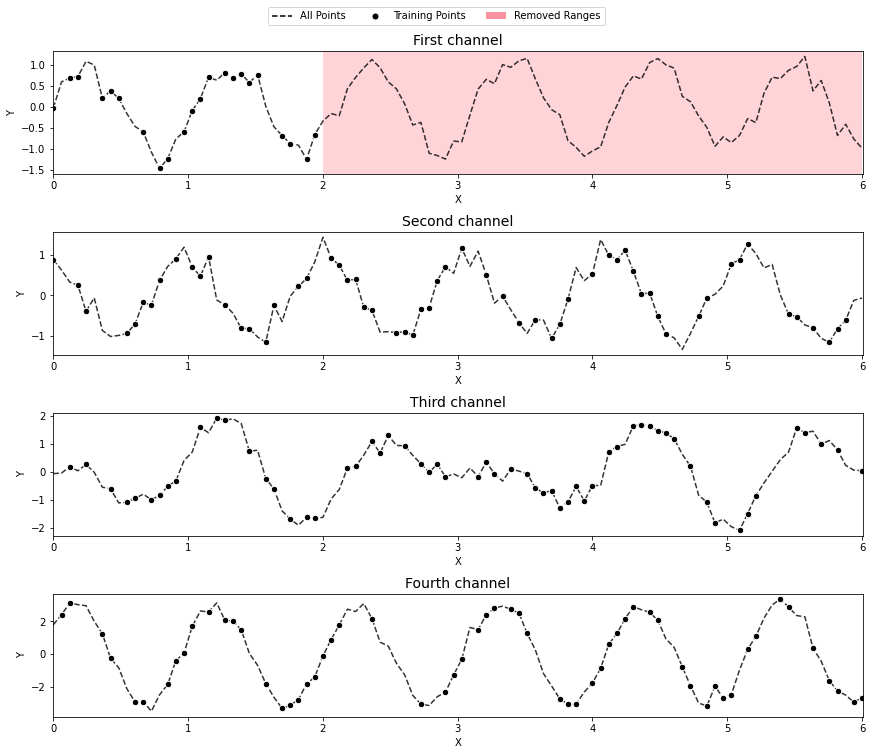

In [5]:
# plot data in time
_, _ = dataset.plot()

As well as the spectrum with [`mogptk.Data.plot_spectrum`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.Data.plot_spectrum) (for this we use the Lomb-Scargle method)

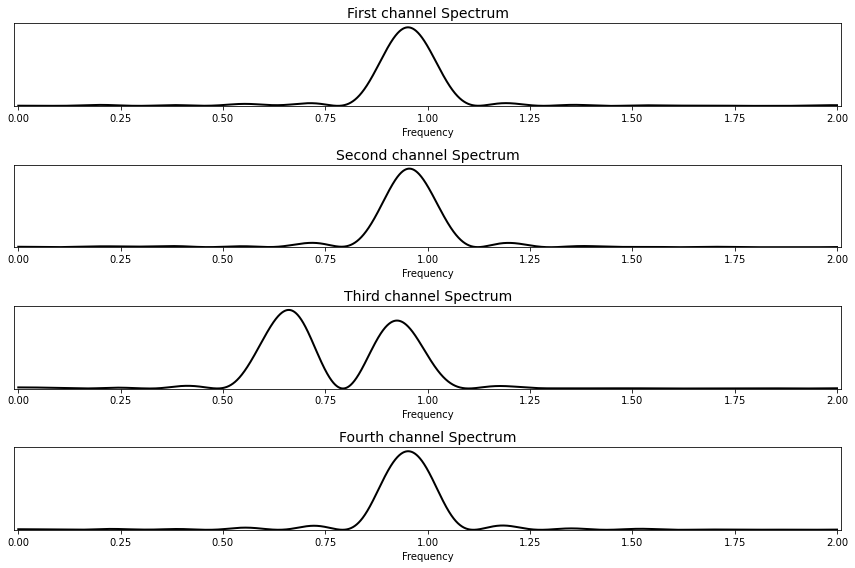

In [6]:
# plot spectrum
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(12, 8))

for i, data in enumerate(dataset):
    data.plot_spectrum(ax=axes[i], maxfreq=2)
plt.tight_layout()

## 2. Models

To use a model we first create an `mogptk.Model` object, then we can initialize the parameters with sound heurisctics and to assist optimization.

When creating the `mogptk.Model` object, we pass the dataset and the number of components (or model order). Initially, the kernel parameters are drawn from a Unif(0, 1), but we can __optionally__ re-initialize them to help the optimization by:

1. 'BNSE': Estimate the PSD for each channel via BNSE (Bayesian nonparametric spectral estimation, Tobar 2019), then utilize the position, magnitude and width of the **estimated spectrum peaks** as spectral means, weights and variance respectively.

2. 'SM': For each channel adjust a single output Gaussian process with spectral mixture kernel (Gaussian process kernels for pattern discovery and extrapolation, Wilson and Adams, 2013), and use said hyperparameters as initial parameters for the kernel.

This is done in the with `model.init_parameters()`, see the documentation of each model or the example [03-Parameter initialization](https://github.com/GAMES-UChile/mogptk/blob/master/examples/03_Parameter_Initialization.ipynb) where each method is covered in more detail.

In [7]:
# create model, uncomment for different kernels 
model = mogptk.MOSM(dataset, Q=2)
# model = mogptk.CSM(dataset, Q=2)
# model = mogptk.SMLMC(dataset, Q=2)
# model = mogptk.CONV(dataset, Q=2)

# initialize parameters of kernel
model.init_parameters()

In [8]:
# we can plot the model parameters
model.print_parameters()

Name,Range,Value
Mixture[0].MOSM.noise,"[1e-08,∞)",[0.01813468 0.01617415 0.03715256 0.15851448]
Mixture[0].MOSM.magnitude,"[1e-08,∞)",[1.25394113 1.19018677 1.50867541 3.69956542]
Mixture[0].MOSM.mean,"[1e-08,∞)",[[0.94144144] [0.9496997 ] [0.66066066] [0.94144144]]
Mixture[0].MOSM.variance,"[1e-08,∞)",[[0.80012256] [0.27737498] [0.27454103] [0.27280258]]
Mixture[0].MOSM.delay,"(-∞,∞)",[[0.] [0.] [0.] [0.]]
Mixture[0].MOSM.phase,"(-∞,∞)",[0. 0. 0. 0.]
Mixture[1].MOSM.noise,"[1e-08,∞)",[0.01813468 0.01617415 0.03715256 0.15851448]
Mixture[1].MOSM.magnitude,"[1e-08,∞)",[0.7770417 0.72412287 1.47722915 2.30975169]
Mixture[1].MOSM.mean,"[1e-08,∞)",[[1.97372372] [0.56981982] [0.92492492] [0.71846847]]
Mixture[1].MOSM.variance,"[1e-08,∞)",[[0.95379898] [0.27900537] [0.26973537] [0.33892434]]


We can obtain a preliminary prediction __before__ training, just by using the pretrained (init) parameters. 

Predictions are done with [`mogptk.Model.predict`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.predict) which either receives or uses an input set with [`mogptk.DataSet.set_prediction_range`](https://games-uchile.github.io/mogptk/dataset.html#mogptk.dataset.DataSet.set_prediction_range) and returns the posterior mean and confidence intervals.

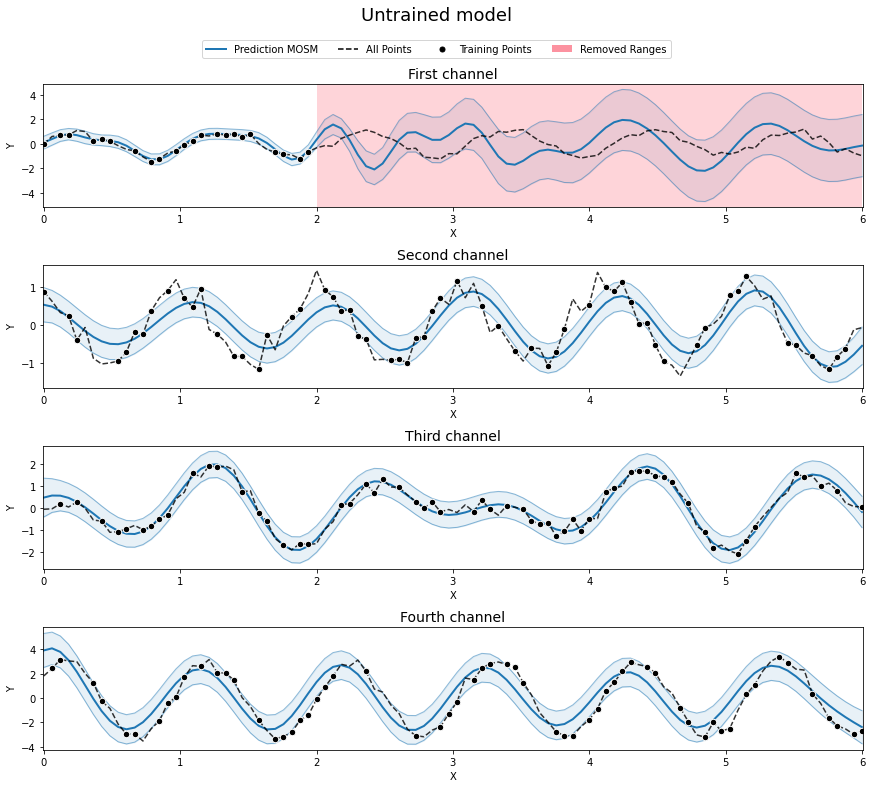

In [9]:
# plot the prediction with untrained model
x_pred = [t for i in range(len(dataset))]
model.predict(x_pred);

dataset.plot(title='Untrained model');

### 2.1 Training
The model can be trained using tensorflow or Scipy optimizers. 

For more info see [04-Model Training](https://github.com/GAMES-UChile/mogptk/blob/master/examples/04_Model_Training.ipynb).

In [10]:
model.train(
    method='Adam',
    iters=500,
    verbose=True)


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 2
‣ Training points: 202
‣ Parameters: 48
‣ Initial NLL: 1.568

Optimization finished in 0.27 minutes
‣ Function evaluations: 500
‣ Final NLL: 0.395


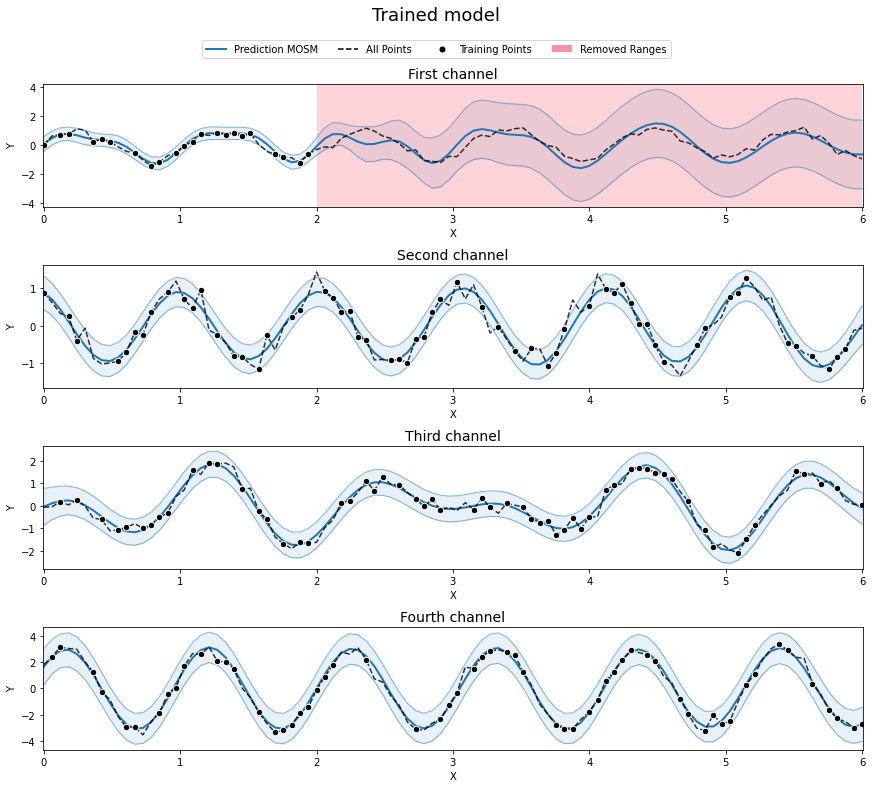

In [11]:
model.predict(x_pred);
dataset.plot(title='Trained model');

## 3. Prediction outside training range

Prediction can be made outside the training range easily using the [`model.predict`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.predict) function.

For this we construct a list of ndarrays with the prediction inputs and the pass it as an argument to [`model.predict`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.predict), so that we obtain the posterior mean, upper and lower confidence intervals. 

Upper and lower confidence intervals are used instead of the standar deviation of the posterior because the toolkit admits tranformations of the dataset (see section 4) and if the transformation is not linear -for example a log transformation- the process in the original domain will not be Gaussian.

In [12]:
# we use the same time for all the channels
input_pred = np.linspace(6, 10, 100)

x_pred = [input_pred for i in range(len(dataset))]

# mean, lower and higher confidence interval
y_pred, y_lo_ci, y_hi_ci = model.predict(x_pred)

The output of the function follows the same structure as the input, a list of length equal to the number of channels, where each element is a numpy array with the predictions on said channel.

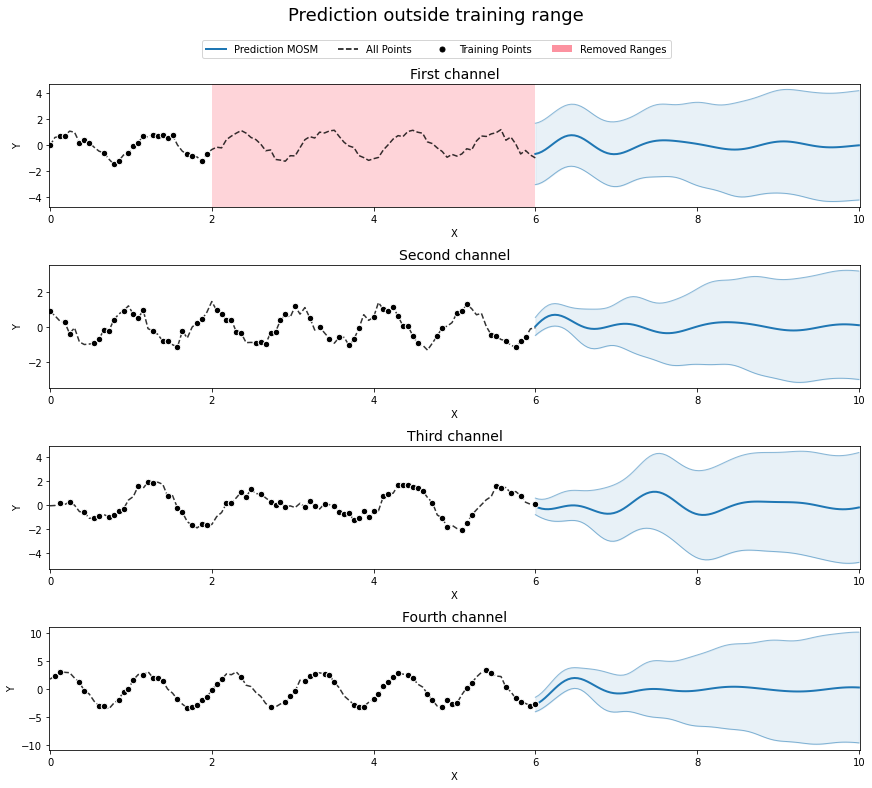

In [13]:
dataset.plot(title='Prediction outside training range');

## 4. Transformations of the data

Currently the toolkit admits the following transformations on channels:

* Normalization.
* Polinomial detrending.
* Logarithmical.

These can be applied successively (i.e., as a function composition), the toolkit keeps track of them to apply the inverse tranformation on the process when doing predictions.

New transformations are straightforward, implementing the forward and backwards methods for each one (the transformation has to be invertible)

As en example, let us apply the exponential function to the original data, for the first 3 channels, and fit the model with the log-transformation for those channels.

For more information and an example of how to construct new transformations see the tutorial [02-Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb)

In [14]:
dataset2 = mogptk.DataSet()

dataset2.append(mogptk.Data(t, np.exp(y1), name='Signal 1'))
dataset2.append(mogptk.Data(t, np.exp(y2), name='Signal 2'))
dataset2.append(mogptk.Data(t, np.exp(y3), name='Signal 3'))
dataset2.append(mogptk.Data(t, y4, name='4'))

for data in dataset2:
    data.remove_randomly(pct=0.3)

dataset2[0].remove_range(start=2.0, end=None)

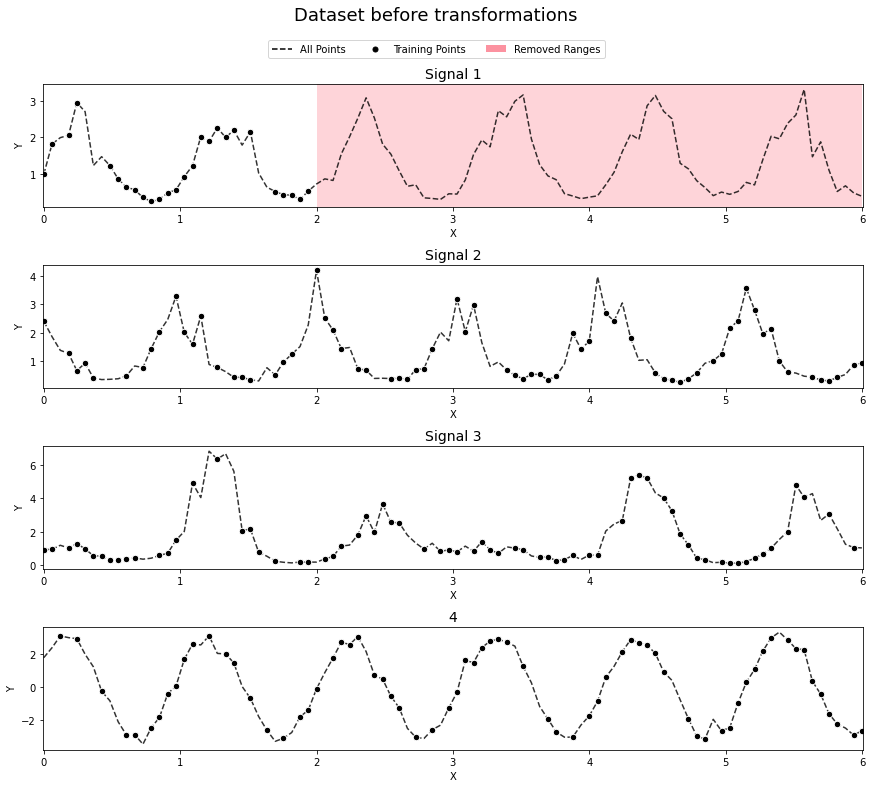

In [15]:
dataset2.plot(title='Dataset before transformations');

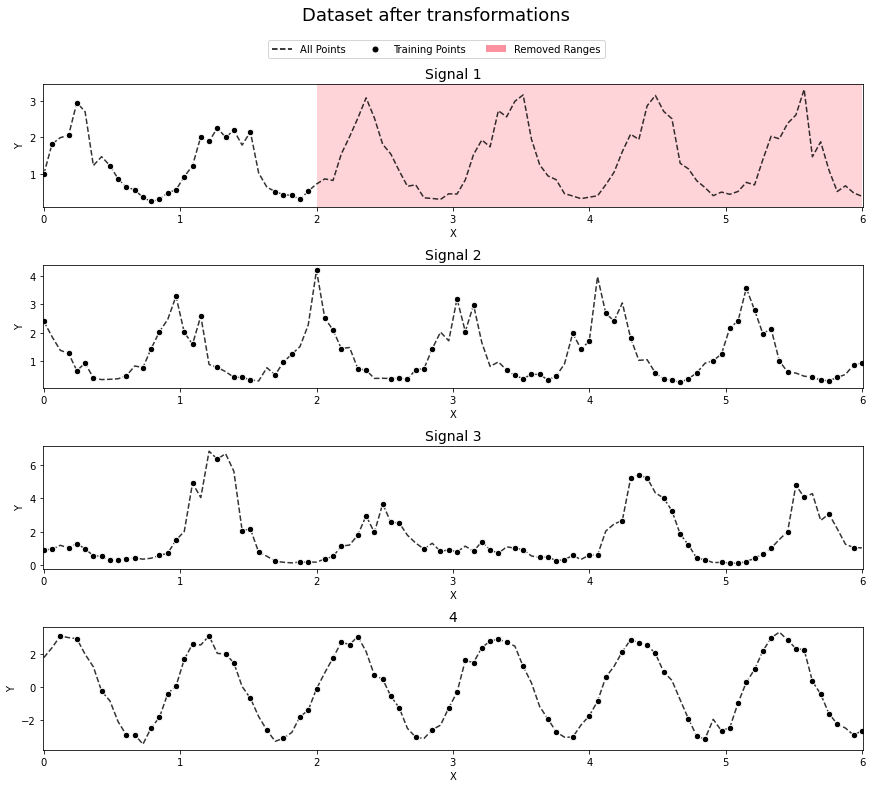

In [16]:
# apply transformations
for data in dataset2[:-1]:
    data.transform(mogptk.TransformLog)
dataset2.plot(title='Dataset after transformations');

In [17]:
model2 = mogptk.MOSM(dataset2, Q=2)
model2.init_parameters('BNSE')
model2.train(iters=600, verbose=True)


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 4
‣ Mixtures: 2
‣ Training points: 236
‣ Parameters: 48
‣ Initial NLL: 2.529

Optimization finished in 0.35 minutes
‣ Function evaluations: 600
‣ Final NLL: 0.064


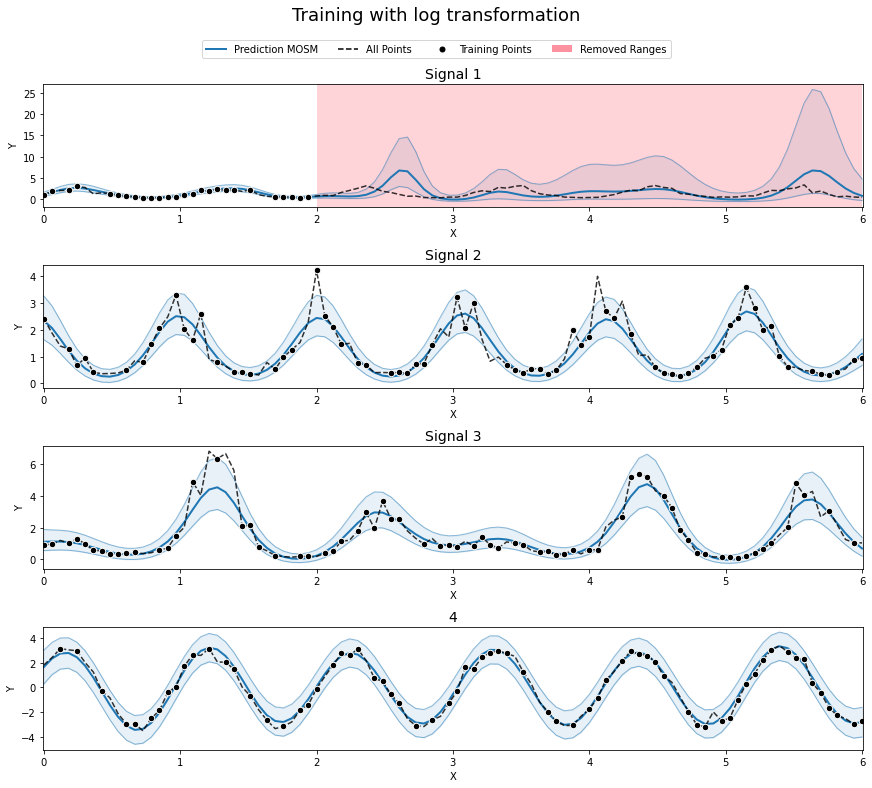

In [18]:
x_pred = [t for i in range(len(dataset2))]
model2.predict(x_pred);
dataset2.plot(title='Training with log transformation');

## 5. Load CSV

The toolkit also allows us to load datasets directly to the model from a csv file with [`mogptk.LoadCSV`](https://games-uchile.github.io/mogptk/data.html#mogptk.data.LoadCSV), where we specify the filename, and the name of the columns for input and output and it returns a Data class object.

As an example, let us load the price of Oil and Gold.

For more information see [01-Data Loading](https://github.com/GAMES-UChile/mogptk/blob/master/examples/01_Data_Loading.ipynb).

In [19]:
oil = mogptk.LoadCSV(filename='data/gonu/brent-daily.csv',
                     x_col='Date',
                     y_col='Price',
                     name='Oil',
                    )
gold = mogptk.LoadCSV(filename='data/gonu/lmba-gold-usd-am-daily.csv',
                      x_col='Date',
                      y_col='Price',
                      name='Gold',
                      na_values='.',
                     )

dataset3 = mogptk.DataSet(oil, gold)

Once the data is loaded, the toolkit can: _filter, agregate by days, remove ranges and set prediction ranges_ by specifying the date range rather than the internal values used as inputs.

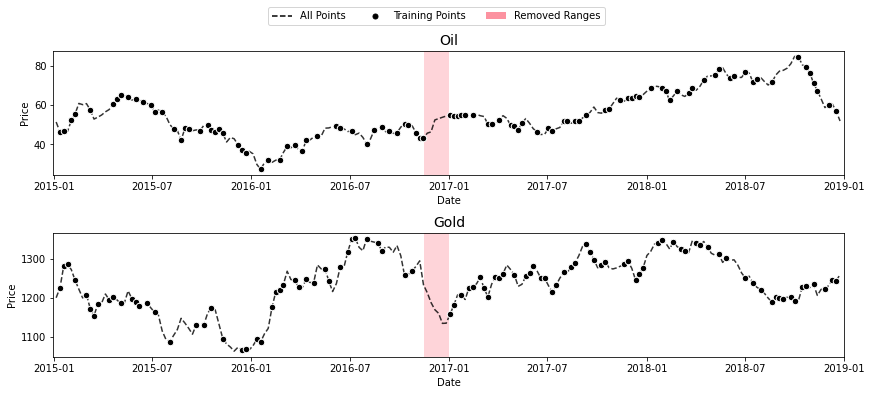

In [20]:
for channel in dataset3:
    # filter by date
    channel.filter('2015-01-01', '2018-12-31')
    # agregate from daily to weekly
    channel.aggregate('7D')
    
    # channel.transform(mogptk.TransformLog)
    channel.transform(mogptk.TransformDetrend(1))
    
    # remove by date range
    channel.remove_range('2016-11-15', '2017-01-01')
    channel.remove_randomly(pct=0.5)
    
    # set prediction range by date
    channel.set_prediction_range('2015-01-01', '2018-12-31', step='1D')
    
dataset3.plot();

We can now train the model normaly and set a prediction range by date

In [21]:
model3 = mogptk.MOSM(dataset3, Q=3)

model3.init_parameters('BNSE')

model3.train(method='Adam', iters=1000, verbose=True)


Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 2
‣ Mixtures: 3
‣ Training points: 200
‣ Parameters: 36
‣ Initial NLL: 5.478

Optimization finished in 0.36 minutes
‣ Function evaluations: 1000
‣ Final NLL: 3.886


We can set the prediction range by dates using [`mogptk.set_prediction_range`](https://games-uchile.github.io/mogptk/dataset.html#mogptk.dataset.DataSet.set_prediction_range) and then predict, in this case we call the predict function without arguments as the range was already set

In [22]:
for i in range(len(dataset3)):    
    model3.dataset[i].set_prediction_range('2015-01-01', '2019-05-01', step='1D')

y_pred, low_ci, hi_ci = model3.predict()

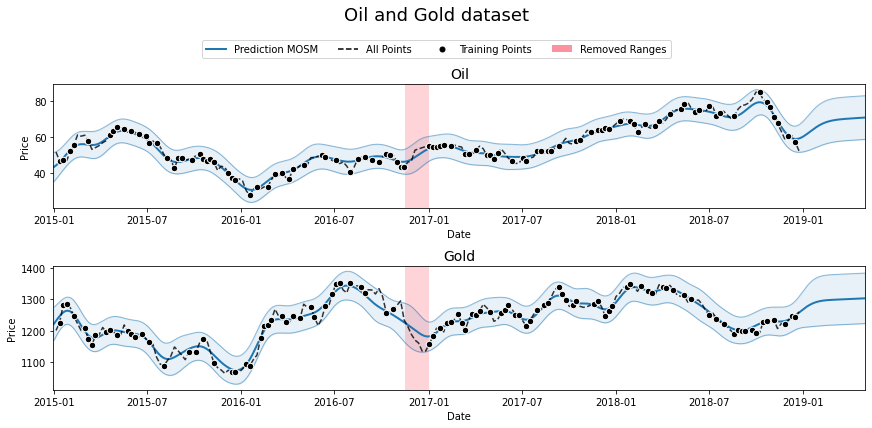

In [23]:
# plot last predicition made
dataset3.plot(title='Oil and Gold dataset');

## 6. Load/Save Models

Models can be saved with [`mogptk.Model.save`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.save), for later use with [`mogptk.LoadModel`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.LoadModel)

In [24]:
# save the first model
model3.save('mosm_example')

In [25]:
# load model
new_model = mogptk.LoadModel('mosm_example')

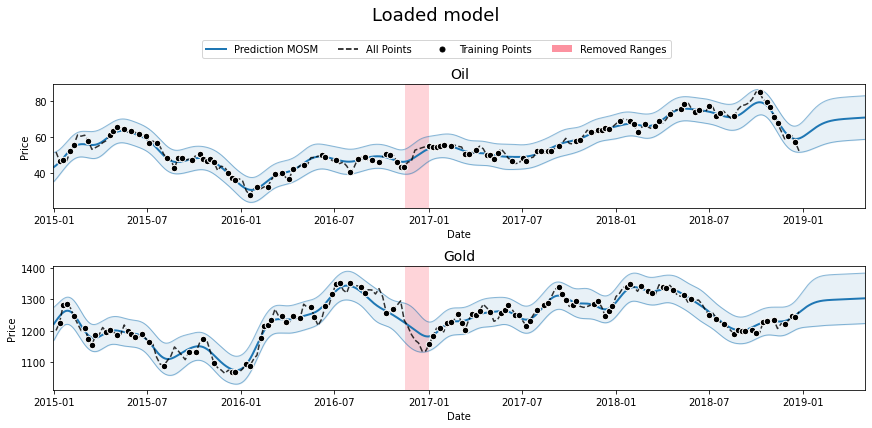

In [26]:
new_model.dataset.plot(title='Loaded model');